# DINOv2 Metrics

This notebook calculates the metrics for the DINOv2 model as per the methodology described in the paper.

In [1]:
# %%
# Change directory to the root of the project
if __name__ == "__main__":
    import os
    import sys

    import dotenv

    os.chdir(os.getcwd().split("notebooks")[0])
    print(f"cwd: {os.getcwd()}")
    dotenv.load_dotenv()
    sys.path.append(os.getenv("PACKAGEPATH", ""))


cwd: /home/andre/wikki/patsa-bil


## Imports and Constants

In [2]:
import copy
import os

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import tqdm

# import torchvision
import torchvision.transforms.v2 as T

from imagelog_ai.features.methodologies.dinov2.datasets.dataset import (
    DINODataset,
)
from imagelog_ai.features.methodologies.dinov2.modules.lit_module import (
    LitDINOv2,
)
from imagelog_ai.features.methodologies.sam.utils.iou import calc_iou
from imagelog_ai.utils.io_functions import json_load

In [3]:
# %%
# Load environment variables
dotenv.load_dotenv(".env", override=True)

True

In [4]:
torch.set_float32_matmul_precision("high")
np.random.seed(0)
torch.manual_seed(0)

OUTPUT_DIR: str = "test_figures"
OVERRIDE: bool = False

pil_transform = T.ToPILImage()
tensor_transform = T.ToImage()


def tensor_to_numpy_transform(x: torch.Tensor) -> np.ndarray:
    return x.numpy().transpose((1, 2, 0))


def collate_fn(batch):
    x = torch.stack([item[0] for item in batch])
    y = [item[1] for item in batch]
    return x, y


ID2LABEL = {0: "background", 1: "foreground"}

In [5]:
# Define checkpoint path
CHECKPOINT_PATH: str = "./12/99c3679a44a948e2acbd2a8ef736087c/checkpoints/epoch=28-step=377.ckpt"

## Datasets

In [ ]:
def transform_func(x):
    """
    Transforms the input tensor by selecting the first three channels.

    Args:
        x (torch.Tensor): Input tensor of shape (C, H, W).

    Returns:
        torch.Tensor: Transformed tensor of shape (3, H, W).
    """
    # Select channels
    x = x[:3, :, :]
    # Convert from RGB to grayscale
    grayscale_transform = T.Grayscale(num_output_channels=3)
    x = grayscale_transform(x)
    # Invert intensities
    x = x.max() - x
    # Convert to float
    x = x.float()
    # Scale to [0, 1]
    x = x / x.max()
    # Resize to (448, 448)
    resize_transform = T.Resize((448, 448))
    x = resize_transform(x)
    return x


def target_transform_func(x):
    """
    Applies transformations to the target data.

    Args:
        x (dict): A dictionary containing the target data.

    Returns:
        dict: The transformed target data.
    """
    # Convert bboxes to float
    x["boxes"] = x["boxes"].float()
    # Binarize labels
    x["labels"] = torch.where(x["labels"] > 0, 1, 0)
    # Convert list of masks to a single 2D mask tensor
    gt_mask = torch.zeros_like(x["masks"][0]).long()
    for mask, label in zip(x["masks"], x["labels"]):
        gt_mask = torch.where(mask > 0, label, gt_mask)
    gt_mask = gt_mask.unsqueeze(0)
    # Resize gt_mask to (448, 448)
    resize_transform = T.Resize((448, 448))
    gt_mask = resize_transform(gt_mask)
    x["gt_mask"] = gt_mask
    return x


project_name = "DINOv2"
project_settings = json_load(f"experiment_configs/{project_name}.json")

# test dataset
dataset = DINODataset(
    project_name,
    project_settings["preprocess_name"],
    project_settings["list_datasource_names"],
    project_settings["class_list"],
    project_settings["others_class_list"],
    project_settings["background_class"],
    transform=transform_func,
    target_transform=target_transform_func,
    target_boxes=True,
    target_labels=True,
    target_masks=True,
    boxes_location="masks",
    masks_location="labels",
)
# Filter dataset rows with "component" == 0
dataset.dataframe = dataset.dataframe[dataset.dataframe["component"] != 0].reset_index(
    drop=True
)
print(dataset.dataframe)

In [7]:
# Separate dataset into train and val (80% train, 20% val)
idxs_train, idxs_test = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=0
)
train_dataset = copy.deepcopy(dataset)
train_dataset.dataframe_dino = dataset.dataframe_dino.copy(deep=True)
train_dataset.dataframe_dino = train_dataset.dataframe_dino.iloc[
    idxs_train
].reset_index(drop=True)
val_dataset = copy.deepcopy(dataset)
val_dataset.dataframe_dino = dataset.dataframe_dino.copy(deep=True)
val_dataset.dataframe_dino = val_dataset.dataframe_dino.iloc[idxs_test].reset_index(
    drop=True
)

In [ ]:
# Iterate on all dataset samples and check if the labels are valid
for idx in tqdm.trange(len(dataset)):
    image, labels, _, _ = dataset[idx]
    # Check if the boxes are valid
    if labels["boxes"].shape[0] == 0:
        print(f"Image {idx} has no boxes.")
    else:
        # Check if the boxes are valid
        for box in labels["boxes"]:
            if box[2] <= box[0] or box[3] <= box[1]:
                print(f"Image {idx} has invalid boxes.")
    # Check if the masks are valid
    if labels["masks"].shape[0] == 0:
        print(f"Image {idx} has no masks.")
    else:
        # Check if the masks are valid
        if labels["masks"].shape[1] == 0:
            print(f"Image {idx} has invalid masks.")

In [ ]:
dataset_images = dataset.dataframe["image_file"].unique()
image_path = dataset_images[0]
print(image_path)
# Get all indexes from the dataset with the same image_path
indexes = dataset.dataframe[dataset.dataframe["image_file"] == image_path].index
print(indexes)

## DINOv2

In [10]:
model = LitDINOv2.load_from_checkpoint(
    CHECKPOINT_PATH,
    pretrained_model_name_or_path="facebook/dinov2-base",
    id2label=ID2LABEL,
    num_labels=len(ID2LABEL),
    batch_size=project_settings["batch_size"],
    early_stopping_patience=16,
    lr_scheduler_patience=8,
    learning_rate=1e-4,
    weight_decay=1e-4,
)
model

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LitDINOv2(
  (model): Dinov2ForSemanticSegmentation(
    (dinov2): Dinov2Model(
      (embeddings): Dinov2Embeddings(
        (patch_embeddings): Dinov2PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): Dinov2Encoder(
        (layer): ModuleList(
          (0-11): 12 x Dinov2Layer(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attention): Dinov2SdpaAttention(
              (attention): Dinov2SdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): Dinov2SelfOutput(
                (dense): Linear(in_features=768, out_features=768, bi

### Plot sample

Image shape: torch.Size([1, 3, 448, 448])
GT Mask shape: torch.Size([1, 448, 448])
Pred Mask shape: torch.Size([1, 448, 448])


Text(0.5, 1.0, 'Pred Mask')

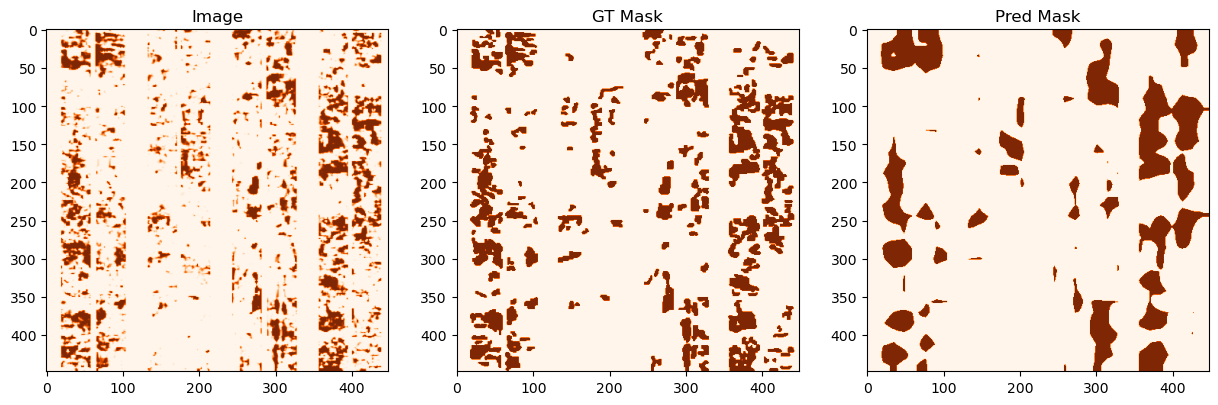

In [11]:
# Plot a sample image, its masks, and the predicted masks
image, labels, image_orig, labels_orig = dataset[0]
image = image.unsqueeze(0)
print(f"Image shape: {image.shape}")
labels = [labels]

gt_mask = labels[0]["gt_mask"]
print(f"GT Mask shape: {gt_mask.shape}")

model.eval()
# evaluate sample on model
with torch.no_grad():
    image = image.to(model.device)
    outputs = model(image)
    loss = outputs.loss
    preds = outputs.logits.argmax(dim=1)
# join mask predictions
pred_mask = preds.cpu()
# pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
# pred_mask = (pred_mask > LitDETR.MASK_THRESHOLD).byte().cpu()
print(f"Pred Mask shape: {pred_mask.shape}")

# Plot images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].imshow(tensor_to_numpy_transform(image[0].cpu()))
axs[0].imshow(image[0][2].cpu(), cmap="Oranges")
axs[0].set_title("Image")
axs[1].imshow(gt_mask[0], cmap="Oranges")
axs[1].set_title("GT Mask")
axs[2].imshow(pred_mask[0].cpu(), cmap="Oranges")
axs[2].set_title("Pred Mask")

### Plot All Samples

In [ ]:
# Plot all samples
for idx in range(len(dataset)):
    image, labels, image_orig, labels_orig = dataset[idx]
    image = image.unsqueeze(0)
    print(f"Image shape: {image.shape}")
    labels = [labels]

    gt_mask = labels[0]["gt_mask"]
    print(f"GT Mask shape: {gt_mask.shape}")

    model.eval()
    # evaluate sample on model
    with torch.no_grad():
        image = image.to(model.device)
        outputs = model(image)
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
    # join mask predictions
    pred_mask = preds.cpu()
    # pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
    # pred_mask = (pred_mask > LitDETR.MASK_THRESHOLD).byte().cpu()
    print(f"Pred Mask shape: {pred_mask.shape}")

    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image[0][2].cpu(), cmap="Oranges")
    axs[0].set_title("Image")
    axs[1].imshow(gt_mask[0], cmap="Oranges")
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask[0], cmap="Oranges")
    axs[2].set_title("Pred Mask")
    plt.show()
    plt.close(fig)

### Plot single sample

Pred Mask shape: torch.Size([1, 448, 448])


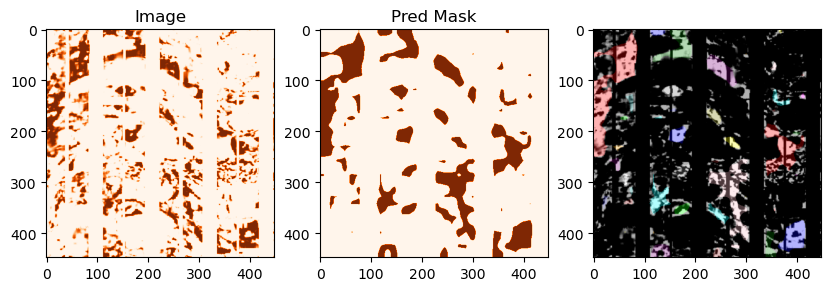

In [17]:
# Set colors
colors = [
    "red",
    "blue",
    "green",
    "yellow",
    "orange",
    "purple",
    "pink",
    "brown",
    "gray",
    "black",
    "white",
    "cyan",
    "magenta",
    "teal",
    "navy",
    "olive",
    "maroon",
    "lime",
    "aqua",
    "silver",
]

image_id = "000106"
IMAGE_COMPARE_PATH = f"data/processed/test_SKLearnODExample/transform_test/WIN_AUG_BBOX_{project_settings['list_datasource_names'][0]}_1/images/{image_id}.pt"
# Load image
image = torch.load(IMAGE_COMPARE_PATH, weights_only=True)
image = image[0, 2, :, :].unsqueeze(0).unsqueeze(0)
# Replicate channel
image = torch.cat([image, image, image], dim=1)
# Normalize to [0, 1]
image = image / image.max()
# Resize to (448, 448)
resize_transform = T.Resize((448, 448))
image = resize_transform(image)
# Forward pass
model.eval()
with torch.no_grad():
    image = image.to(model.device)
    outputs = model(image)
    loss = outputs.loss
    preds = outputs.logits.argmax(dim=1)
# join mask predictions
image = image.cpu()
pred_mask = preds.cpu()
print(f"Pred Mask shape: {pred_mask.shape}")
pred_components = skimage.measure.label(
    pred_mask[0].numpy(), background=0
)
# Plot images
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image[0][0], cmap="Oranges")
axs[0].set_title("Image")
axs[1].imshow(pred_mask[0], cmap="Oranges")
axs[1].set_title("Pred Mask")
axs[2].imshow(
    label2rgb(
        label=np.array(pred_components),
        image=np.array(image[0][0]),
        colors=colors,
        bg_label=0,
    )
)
plt.show()

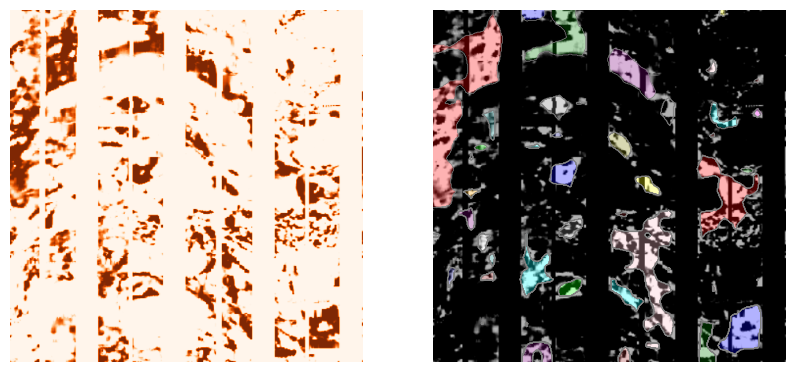

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image[0][0].cpu(), cmap="Oranges")
ax[0].axis("off")
ax[1].imshow(
    label2rgb(
        label=np.array(pred_components),
        image=np.array(image[0][0]),
        colors=colors,
        bg_label=0,
    )
)
ax[1].contour(np.array(pred_components), colors="gray", linewidths=0.5)
ax[1].axis("off")
# Save figure
plt.savefig(os.path.join(f"dinov2_welld_{image_id}.png"), bbox_inches="tight", dpi=300)

### Compute metrics

In [ ]:
map_metric = MeanAveragePrecision(
    iou_type="segm", iou_thresholds=np.arange(start=0.05, stop=1.00, step=0.05).tolist(), extended_summary=True
)
ious = []
maps = []
model.eval()
for idx in range(len(dataset)):
    print(f"Processing image {idx + 1}/{len(dataset)}")
    image, labels, image_orig, labels_orig = dataset[idx]
    image = image.unsqueeze(0)
    print(f"Image shape: {image.shape}")
    labels = [labels]

    gt_mask = labels[0]["gt_mask"]
    print(f"GT Mask shape: {gt_mask.shape}")

    model.eval()
    # evaluate sample on model
    with torch.no_grad():
        image = image.to(model.device)
        outputs = model(image)
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
    # join mask predictions
    pred_mask = preds.cpu()
    # pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
    # pred_mask = (pred_mask > LitDETR.MASK_THRESHOLD).byte().cpu()
    # Resize pred_mask and gt_mask to (360, 360)
    resize_transform = T.Resize((360, 360))
    pred_mask = resize_transform(pred_mask).byte()
    gt_mask = resize_transform(gt_mask).byte()
    print(f"Pred Mask shape: {pred_mask.shape}")
    print(f"GT Mask shape: {gt_mask.shape}")
    # Calculate IoU
    iou = calc_iou(pred_mask, gt_mask)
    # Calculate mAP
    map_preds = [
        {
            "masks": pred_mask,
            "scores": torch.tensor([1.0]),
            "labels": torch.tensor([1]),
        }
    ]
    map_target = [
        {
            "masks": gt_mask,
            "labels": torch.tensor([1]),
        }
    ]
    maps.append(map_metric(preds=map_preds, target=map_target))
    # maps.append(map_metric(preds=preds, target=[target]))
    ious.append(iou)
    mean_iou = np.mean(ious)
    print(f"IoU: {iou} (Mean: {mean_iou})")
    print("maps:", [map["map"] for map in maps])
    print("mean maps:", np.mean([map["map"] for map in maps]))
    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    image = image.cpu()
    # Resize image to (360, 360)
    resize_transform = T.Resize((360, 360))
    image = resize_transform(image)
    pred_components = skimage.measure.label(
        pred_mask[0].numpy(), background=0
    )
    axs[0].imshow(image[0][0], cmap="Oranges")
    axs[0].set_title("Image")
    axs[1].imshow(pred_mask[0], cmap="Oranges")
    axs[1].set_title("Pred Mask")
    axs[2].imshow(
        label2rgb(
            label=np.array(pred_components),
            image=np.array(image[0][0]),
            colors=colors,
            bg_label=0,
        )
    )
    plt.show()

In [ ]:
print(f"Mean IoU: {np.mean(ious)}")
map_metric.compute()